# Object detection and masking from prompts with GroundedSAM (GroundingDINO + SAM) and OpenVINO

In this notebook, we provide the OpenVINO™ optimization for combination of GroundingDINO + SAM = [GroundedSAM](https://github.com/IDEA-Research/Grounded-Segment-Anything) on Intel® platforms. GroundedSAM aims to detect and segment anything with text inputs. GroundingDINO is a language-guided query selection module to enhance object detection using input text. It selects relevant features from image and text inputs and returns predicted box with detections.

The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. We use box predictions from GroundingDINO to mask original image.

More details about model can be found in [paper](https://arxiv.org/abs/2401.14159) and official [repository](https://github.com/IDEA-Research/Grounded-Segment-Anything).

![image](https://github.com/openvinotoolkit/openvino_notebooks/assets/5703039/3c19063a-c60a-4d5d-b534-e1305a854180)

#### Table of contents:
- [Clone repository and install requirements](#Clone-repository-and-install-requirements)
- [Download checkpoints and load PyTorch model](#Download-checkpoints-and-load-PyTorch-model)
- [Convert GroundingDINO to OpenVINO IR format](#Convert-GroundingDINO-to-OpenVINO-IR-format)
- [Run OpenVINO optimized GroundingDINO](#Run-OpenVINO-optimized-GroundingDINO)
- [Convert SAM to OpenVINO IR](#Convert-SAM-to-OpenVINO-IR)
- [Combine GroundingDINO + SAM (GroundedSAM)](#Combine-GroundingDINO-+-SAM-(GroundedSAM))
- [Interactive GroundedSAM](#Interactive-GroundedSAM)
- [Clear](#Clear)


## Clone repositories and install requirements
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q timm --extra-index-url https://download.pytorch.org/whl/cpu # is needed for torch

In [ ]:
%pip install -q "openvino-nightly>=2024.1.0.dev20240219" opencv-python supervision transformers yapf pycocotools addict gradio

In [3]:
from pathlib import Path
import sys
import os

repo_dir = Path("Grounded-Segment-Anything")
ground_dino_dir = Path('GroundingDINO')

# we use grounding dino from a fork which contains modifications that allow conversion to OpenVINO IR format
if not ground_dino_dir.exists():
    !git clone https://github.com/wenyi5608/GroundingDINO/
if not repo_dir.exists():
    !git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

# append to sys.path so that modules from the repo could be imported
sys.path.append(str(ground_dino_dir))
sys.path.append(str(repo_dir / 'segment_anything'))

In [4]:
import torch
import numpy as np
import supervision as sv
import openvino as ov
from PIL import Image, ImageDraw, ImageFont
from typing import Union, List

core = ov.Core()

## Download checkpoints and load PyTorch model
[back to top ⬆️](#Table-of-contents:)

In [5]:
IRS_PATH = Path('openvino_irs')
CKPT_BASE_PATH = Path('checkpoints')
os.makedirs(IRS_PATH, exist_ok=True)
os.makedirs(CKPT_BASE_PATH, exist_ok=True)

PT_DEVICE = 'cpu'
ov_dino_name = 'openvino_grounding_dino'
ov_sam_name = 'openvino_segment_anything'

ground_dino_img_size = (1024, 1280)

# GroundingDINO config and checkpoint 
GROUNDING_DINO_CONFIG_PATH = f"{repo_dir}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = CKPT_BASE_PATH / "groundingdino_swint_ogc.pth"
# Segment-Anything checkpoint
SAM_CHECKPOINT_PATH = CKPT_BASE_PATH / "sam_vit_h_4b8939.pth"

In [6]:
# Fetch `notebook_utils` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/main/notebooks/utils/notebook_utils.py',
    filename='notebook_utils.py'
)
from notebook_utils import download_file

download_file("https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth", directory=CKPT_BASE_PATH)
download_file("https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth", directory=CKPT_BASE_PATH)

'checkpoints/groundingdino_swint_ogc.pth' already exists.
'checkpoints/sam_vit_h_4b8939.pth' already exists.


PosixPath('/home/epavel/devel/openvino_notebooks/notebooks/287-grounded-segment-anything/checkpoints/sam_vit_h_4b8939.pth')

In [7]:
def load_pt_grounding_dino(model_config_path, model_checkpoint_path, cpu_only=True):
    from groundingdino.models import build_model
    from groundingdino.util.slconfig import SLConfig
    from groundingdino.util.utils import clean_state_dict

    args = SLConfig.fromfile(model_config_path)
    
    # modified config
    args.device = PT_DEVICE
    args.use_checkpoint = False
    args.use_transformer_ckpt = False
    
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    _ = model.eval()
    return model

In [8]:
# Building GroundingDINO inference model
pt_grounding_dino_model = load_pt_grounding_dino(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)

from segment_anything import build_sam, SamPredictor

# Building SAM Model and SAM Predictor
sam = build_sam(checkpoint=SAM_CHECKPOINT_PATH).to(PT_DEVICE)
sam_predictor = SamPredictor(sam)

/home/epavel/devel/openvino_notebooks/notebooks/287-grounded-segment-anything/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")
/home/epavel/opt/envs/py310-grounding-sam-test/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


### Convert GroundingDINO to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

In order to convert valid example inputs are necessary

In [9]:
ov_dino_path = IRS_PATH / f'{ov_dino_name}.xml'

if not ov_dino_path.exists():
    caption = "the running dog ."
    input_ids = pt_grounding_dino_model.tokenizer([caption], return_tensors="pt")["input_ids"]
    position_ids = torch.tensor([[0, 0, 1, 2, 3, 0]])
    token_type_ids = torch.tensor([[0, 0, 0, 0, 0, 0]])
    attention_mask = torch.tensor([[True, True, True, True, True, True]])
    text_token_mask = torch.tensor([[
        [True, False, False, False, False, False],
        [False, True, True, True, True, False],
        [False, True, True, True, True, False],
        [False, True, True, True, True, False],
        [False, True, True, True, True, False],
        [False, False, False, False, False, True]
    ]])
    img = torch.randn(1, 3, *ground_dino_img_size)
    dummpy_inputs = img, input_ids, attention_mask, position_ids, token_type_ids, text_token_mask

    pt_grounding_dino_model.eval()
    for par in pt_grounding_dino_model.parameters():
        par.requires_grad = False
    traced_model = torch.jit.trace(pt_grounding_dino_model, example_inputs=dummpy_inputs, strict=False, check_trace=False)

    ov_dino_model = ov.convert_model(traced_model, example_input=dummpy_inputs)
    ov.save_model(ov_dino_model, ov_dino_path)
else:
    ov_dino_model = core.read_model(ov_dino_path)

/home/epavel/opt/envs/py310-grounding-sam-test/lib/python3.10/site-packages/transformers/modeling_utils.py:962: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/epavel/devel/openvino_notebooks/notebooks/287-grounded-segment-anything/GroundingDINO/groundingdino/models/GroundingDINO/groundingdino.py:264: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if encoded_text.shape[1] > self.max_text_len:
/home/epavel/devel/openvino_notebooks/notebooks/287-grounded-segment-anything/GroundingDINO/groundingdino/util/misc.py:506: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or s

### Run OpenVINO optimized GroundingDINO
[back to top ⬆️](#Table-of-contents:)

In [10]:
import ipywidgets
device_widget = ipywidgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)
device_widget

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [11]:
def build_compiled_model(model_config_path, ov_dino_model, device):
    from groundingdino.util import get_tokenlizer
    from groundingdino.util.slconfig import SLConfig
    
    model = core.compile_model(ov_dino_model, device.upper())
    args = SLConfig.fromfile(model_config_path)
    model.tokenizer = get_tokenlizer.get_tokenlizer(args.text_encoder_type)
    model.max_text_len = args.max_text_len
    return model

device = device_widget.value
ov_compiled_grounded_dino = build_compiled_model(GROUNDING_DINO_CONFIG_PATH, ov_dino_model, device)

final text_encoder_type: bert-base-uncased


In [12]:
def get_ov_grounding_output(model: ov.CompiledModel, image, caption: Union[str, List[str]], box_threshold, 
                            text_threshold=None, 
                            with_logits=True):
    from groundingdino.util.utils import get_phrases_from_posmap
    from groundingdino.models.GroundingDINO.bertwarper import generate_masks_with_special_tokens_and_transfer_map

    assert text_threshold is not None or token_spans is not None, "text_threshould and token_spans should not be None at the same time!"
    if isinstance(caption, list):
        caption = '. '.join(caption)
    
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
        
    captions = [caption]
    # encoder texts
    tokenized = model.tokenizer(captions, padding="longest", return_tensors="pt")
    specical_tokens = model.tokenizer.convert_tokens_to_ids(["[CLS]", "[SEP]", ".", "?"])
    
    (
        text_self_attention_masks,
        position_ids,
        cate_to_token_mask_list,
    ) = generate_masks_with_special_tokens_and_transfer_map(
        tokenized, specical_tokens, model.tokenizer)

    if text_self_attention_masks.shape[1] > model.max_text_len:
        text_self_attention_masks = text_self_attention_masks[
            :, : model.max_text_len, : model.max_text_len]
        
        position_ids = position_ids[:, : model.max_text_len]
        tokenized["input_ids"] = tokenized["input_ids"][:, : model.max_text_len]
        tokenized["attention_mask"] = tokenized["attention_mask"][:, : model.max_text_len]
        tokenized["token_type_ids"] = tokenized["token_type_ids"][:, : model.max_text_len]

    inputs = {}
    
    # TODO: write explanation why it's needed
    from torchvision.transforms.functional import resize, InterpolationMode
    pre_image = torch.from_numpy(image) if isinstance(image, np.ndarray) else image
    image_ = resize(pre_image, ground_dino_img_size, interpolation=InterpolationMode.BICUBIC)
    input_img = np.expand_dims(image_, 0)

    inputs["samples"] = input_img
    inputs["attention_mask.1"] = tokenized["attention_mask"]
    inputs["text_self_attention_masks"] = text_self_attention_masks 
    inputs["input_ids"] = tokenized["input_ids"]
    inputs["position_ids"] = position_ids
    inputs["token_type_ids"] = tokenized["token_type_ids"]

    # ov inference
    request = model.create_infer_request()
    request.start_async(inputs, share_inputs=False)
    request.wait()
    outputs = {}
    outputs["logits"] = request.get_tensor("pred_logits").data
    outputs["boxes"] = request.get_tensor("pred_boxes").data
       
    def sig(x):
        return 1 / (1 + np.exp(-x))
    
    prediction_logits_ = np.squeeze(outputs["logits"], 0)
    prediction_logits_ = sig(prediction_logits_)
    prediction_boxes_ = np.squeeze(outputs["boxes"], 0)
    logits = torch.from_numpy(prediction_logits_)
    boxes = torch.from_numpy(prediction_boxes_)
    
    # filter output
    logits_filt = logits.cpu().clone()
    boxes_filt = boxes.cpu().clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases, logits_filt.max(dim=1)[0]

In [13]:
SOURCE_IMAGE_PATH = f"{repo_dir}/assets/demo7.jpg"
BOX_THRESHOLD = 0.25
TEXT_THRESHOLD = 0.25
NMS_THRESHOLD = 0.8

In [14]:
def transform_image(image_pil):
    import groundingdino.datasets.transforms as T
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image

pil_image = Image.open(SOURCE_IMAGE_PATH)
image = np.array(pil_image)
transformed_image = np.array(transform_image(pil_image))

In [15]:
classes_prompt = ["Horse", "Clouds", "Grasses", "Sky", "Hill"]

In [16]:
boxes_filt, pred_phrases, logits_filt = get_ov_grounding_output(
    ov_compiled_grounded_dino,
    transformed_image,
    classes_prompt,
    BOX_THRESHOLD, TEXT_THRESHOLD
)

from groundingdino.util.inference import Model
source_w, source_h = pil_image.size
detections = Model.post_process_result(
    source_h=source_h,
    source_w=source_w,
    boxes=boxes_filt,
    logits=logits_filt)

class_id = Model.phrases2classes(phrases=pred_phrases, classes=list(map(str.lower, classes_prompt)))
detections.class_id = class_id

Draw the annotations

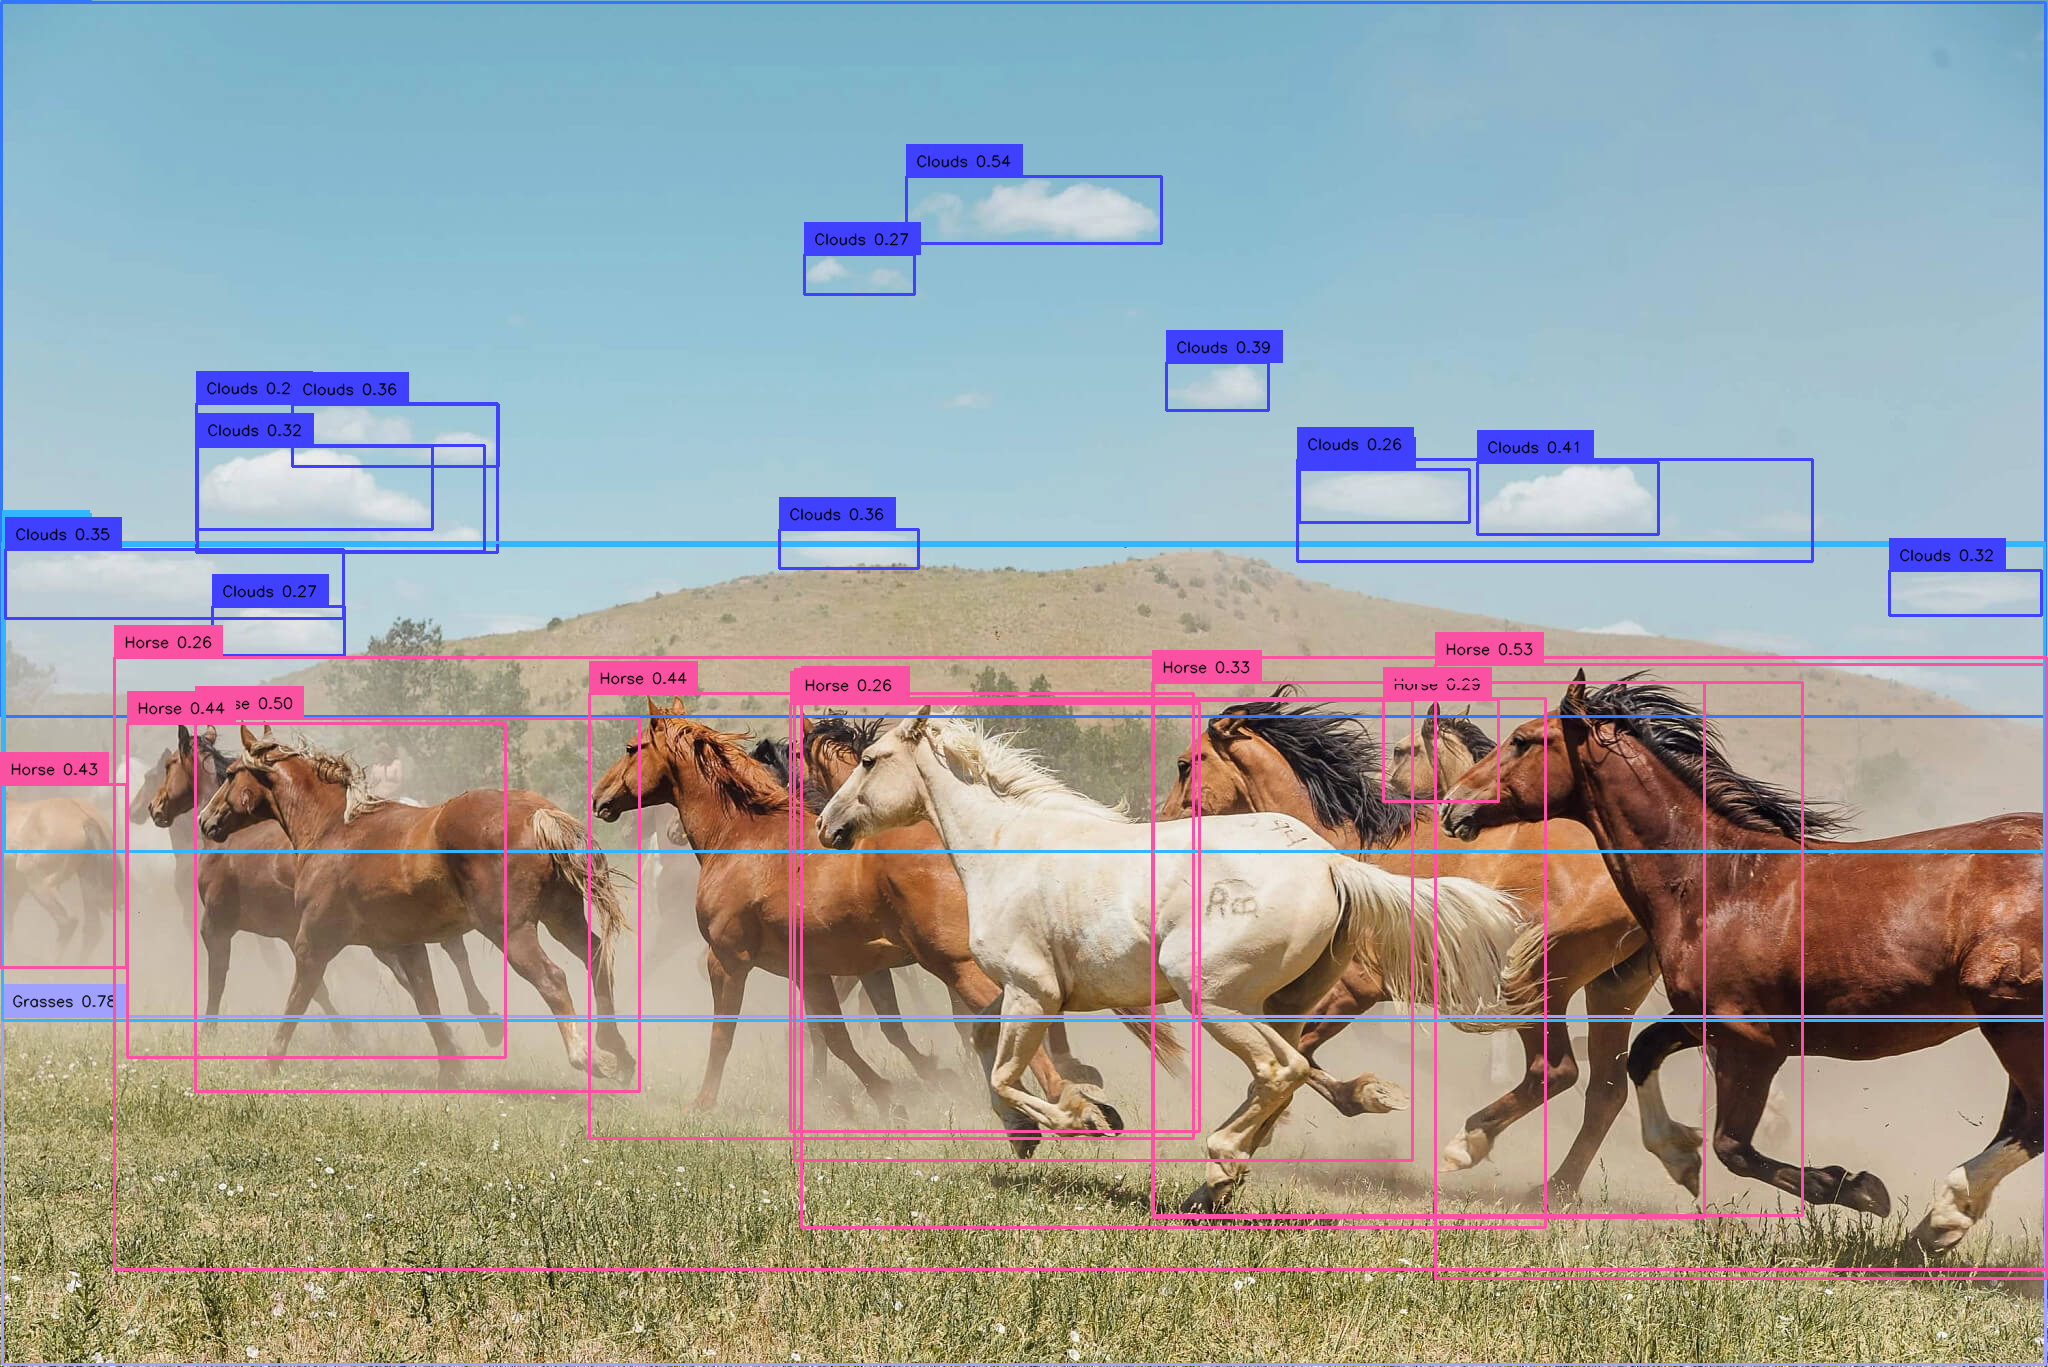

In [17]:
box_annotator = sv.BoxAnnotator()
labels = [
    f"{classes_prompt[class_id] if class_id is not None else 'None'} {confidence:0.2f}"
    for _, _, confidence, class_id, _, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

Image.fromarray(annotated_frame)

### Convert SAM to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

And now let's feed those detection to SAM model. Firstly we need to convert SAM to OpenVINO format.

Image pre/post processing utils

In [18]:
class SamMaskFromBoxes(torch.nn.Module):
    def __init__(
        self,
        sam_predictor,
    ) -> None:
        super().__init__()
        self.model = sam_predictor

    @torch.no_grad()
    def forward(
        self,
        input_image: torch.Tensor,
        transformed_boxes: torch.Tensor,
        multimask_output: bool = False,
        hq_token_only: bool = False,
    ):
        pre_processed_image = self.model.model.preprocess(input_image)
        image_embeddings, interm_features = self.model.model.image_encoder(pre_processed_image)
        
        # Embed prompts
        sparse_embeddings, dense_embeddings = self.model.model.prompt_encoder(
            points=None,
            boxes=transformed_boxes,
            masks=None,
        )

        # Predict masks
        low_res_masks, iou_predictions = self.model.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output,
            hq_token_only=hq_token_only,
            interm_embeddings=interm_features,
        )

        return low_res_masks, iou_predictions, low_res_masks

export SAM to IR

In [19]:
exportable = SamMaskFromBoxes(sam_predictor)

exportable.model.model.eval()
for par in exportable.model.model.parameters():
    par.requires_grad = False

example_image = np.array(Image.open(SOURCE_IMAGE_PATH).convert("RGB"))
transfromed_example_image = exportable.model.transform.apply_image(example_image)
input_image_torch = torch.as_tensor(transfromed_example_image, device=PT_DEVICE)
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

dummy_transformed_boxes = torch.rand(1, 4, dtype=torch.float32) * 200

In [20]:
ov_sam_path = IRS_PATH / f'{ov_sam_name}.xml'
if not ov_sam_path.exists():   
    traced = torch.jit.trace(exportable, example_inputs=(input_image_torch, dummy_transformed_boxes))
    ov_sam = ov.convert_model(traced, example_input=(input_image_torch, dummy_transformed_boxes))
    ov.save_model(ov_sam, ov_sam_path)
else:
    ov_sam = core.read_model(ov_sam_path)

/home/epavel/devel/openvino_notebooks/notebooks/287-grounded-segment-anything/Grounded-Segment-Anything/segment_anything/segment_anything/modeling/image_encoder.py:261: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if pad_h > 0 or pad_w > 0:
/home/epavel/devel/openvino_notebooks/notebooks/287-grounded-segment-anything/Grounded-Segment-Anything/segment_anything/segment_anything/modeling/image_encoder.py:307: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max_rel_dist = int(2 * max(q_size, k_size) - 1)
/home/epavel/devel/openvino_notebooks/notebooks/287-g

In [21]:
ov_sam_compiled = core.compile_model(ov_sam, device_name=device)

### Combine GroundingDINO + SAM (GroundedSAM)
[back to top ⬆️](#Table-of-contents:)

In [22]:
def predict_masks(predictor, image, transformed_boxes):
    transfromed_example_image = exportable.model.transform.apply_image(image)
    input_image_torch = torch.as_tensor(transfromed_example_image, device=PT_DEVICE)
    input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    original_size = tuple(image.shape[:2])
    input_size = tuple(input_image_torch.shape[-2:])

    low_res_masks = predictor((input_image_torch, transformed_boxes))[0]
    
    # Upscale the masks to the original image resolution
    masks = exportable.model.model.postprocess_masks(torch.from_numpy(low_res_masks), input_size, original_size)
    masks = masks > exportable.model.model.mask_threshold
    return masks

In [23]:
def transform_boxes(sam_predictor, boxes, size):
    H, W = size[0], size[1]
    for i in range(boxes.size(0)):
        boxes[i] = boxes[i] * torch.Tensor([W, H, W, H])
        boxes[i][:2] -= boxes[i][2:] / 2
        boxes[i][2:] += boxes[i][:2]

    return sam_predictor.transform.apply_boxes_torch(boxes, size).to(PT_DEVICE)

In [24]:
transformed_boxes = transform_boxes(sam_predictor, boxes_filt, image.shape[:2])
masks = predict_masks(ov_sam_compiled, image, transformed_boxes)

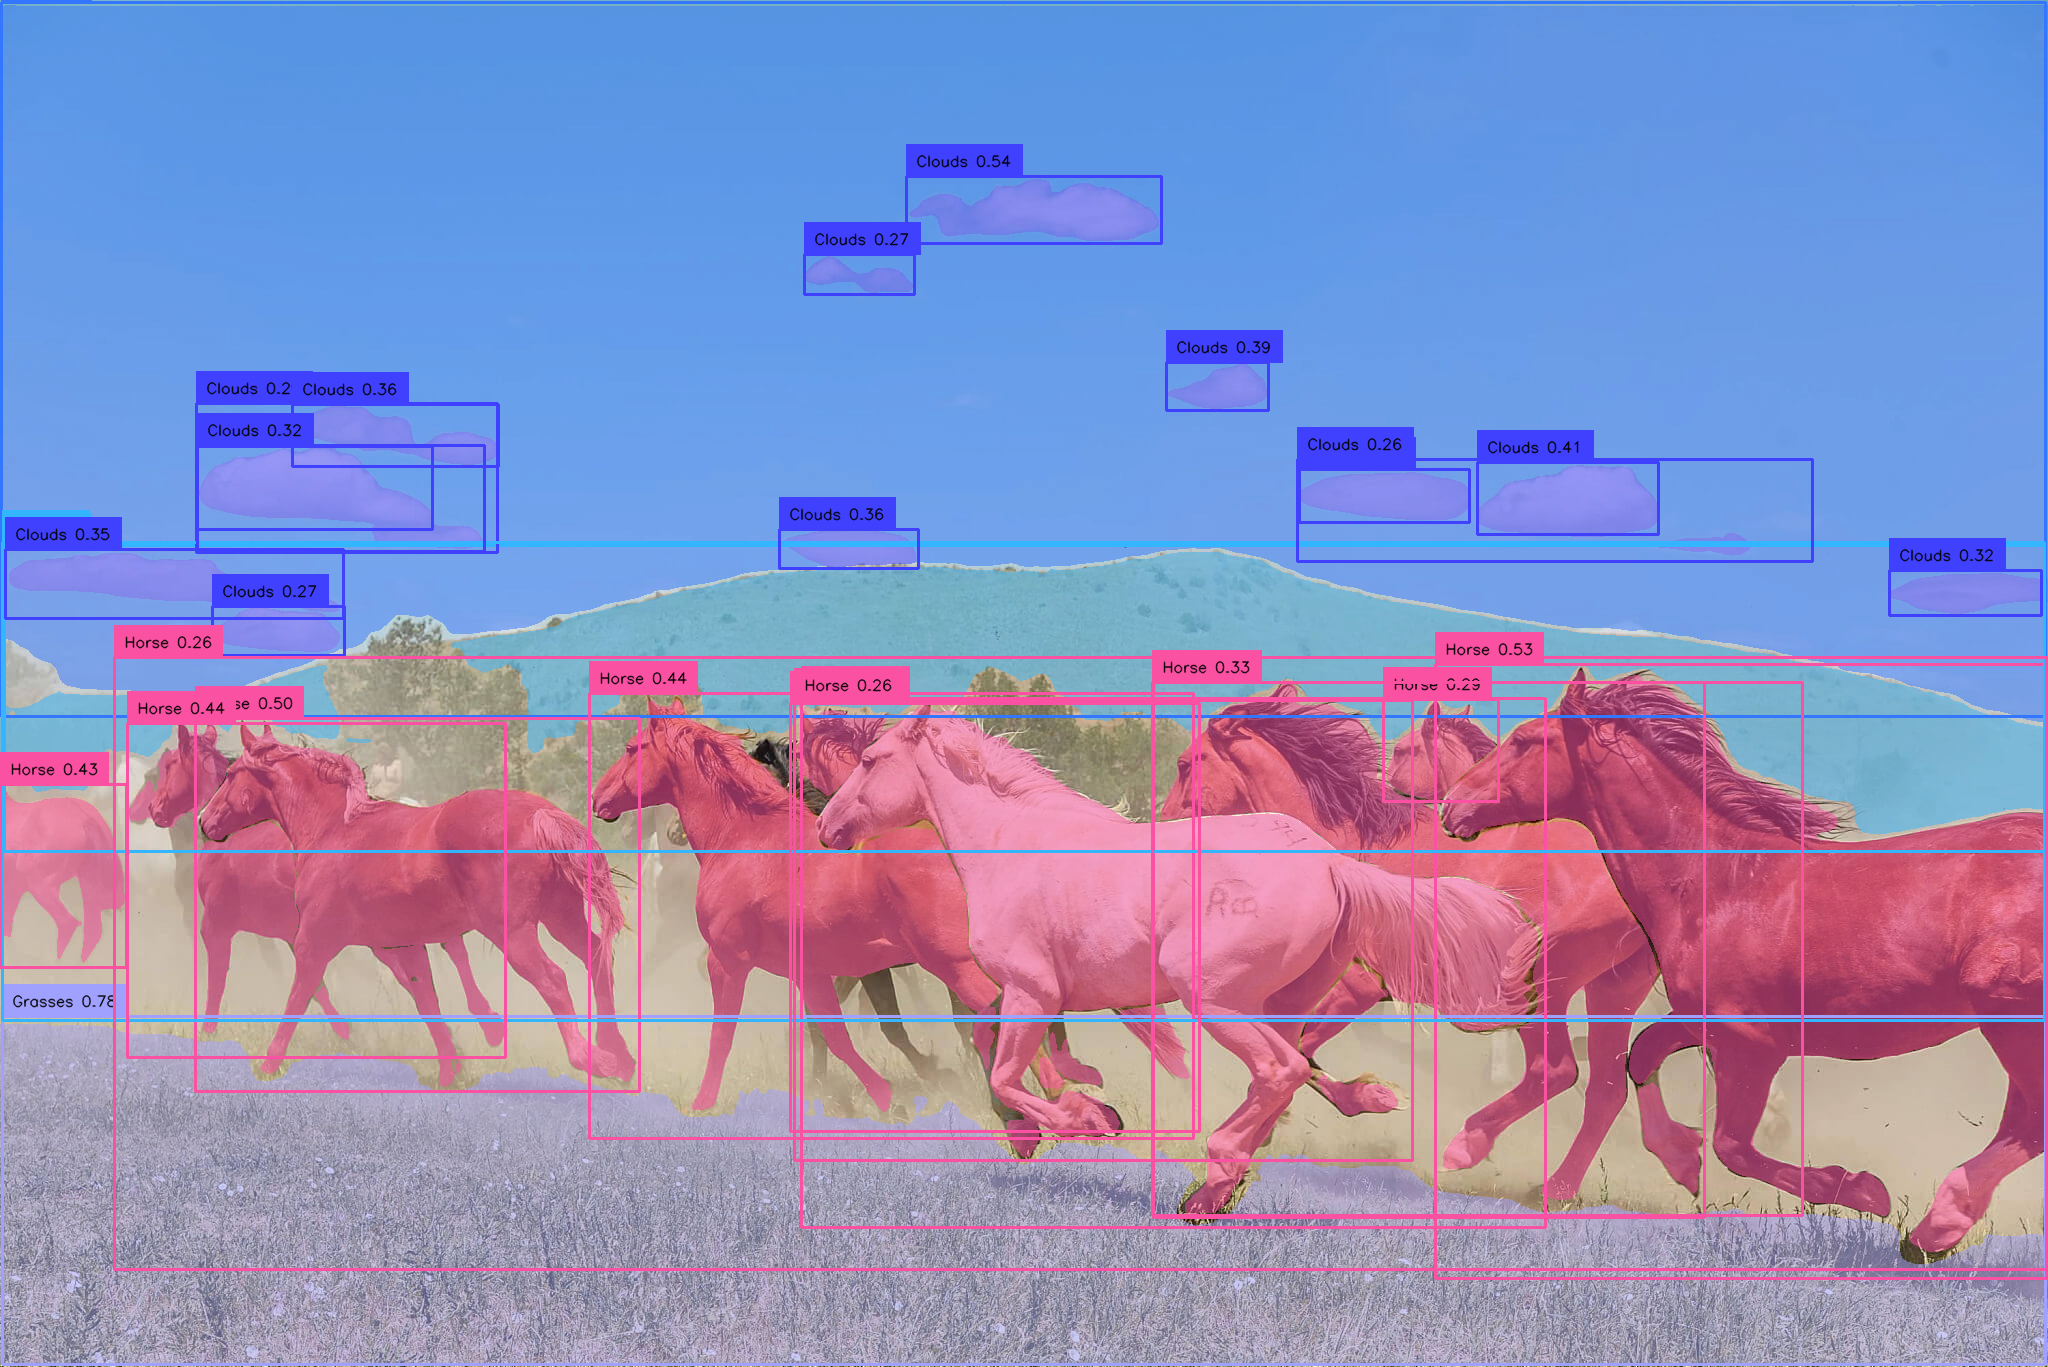

In [25]:
# convert masks detections
detections.mask = masks[:, 0].numpy()

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

Image.fromarray(annotated_image)

### Interactive GroundedSAM
[back to top ⬆️](#Table-of-contents:)

run grounding sam

In [26]:
import gradio as gr

In [27]:
def run_grounding_sam(input_image, task_type, text_prompt, box_threshold, text_threshold, iou_threshold): 
    # image = input_image['image']
    # size = image.size  # w, h
    # image_pil = image.convert("RGB")
    # image = np.array(image_pil)
    
    image = input_image
    image_pil = Image.fromarray(image)
    size = image.shape[1], image.shape[0]  # size is WH image.shape HWC
    
    transformed_image = transform_image(image_pil)
    
    boxes_filt, scores, pred_phrases = get_ov_grounding_output(
        ov_compiled_grounded_dino, 
        transformed_image, 
        text_prompt, 
        box_threshold, 
        text_threshold
    )

    # process boxes
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()

    if task_type == 'seg':
        transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(PT_DEVICE)
        masks = predict_masks(ov_sam_compiled, image, transformed_boxes)

        mask_image = Image.new('RGBA', size, color=(0, 0, 0, 0))
        mask_draw = ImageDraw.Draw(mask_image)
        for mask in masks:
            draw_mask(mask[0].cpu().numpy(), mask_draw, random_color=True)

        image_draw = ImageDraw.Draw(image_pil)
        for box, label in zip(boxes_filt, pred_phrases):
            draw_box(box, image_draw, label)

        image_pil = image_pil.convert('RGBA')
        image_pil.alpha_composite(mask_image)

        return [image_pil, mask_image]
    if task_type == 'det':
        image_draw = ImageDraw.Draw(image_pil)
        for box, label in zip(boxes_filt, pred_phrases):
            draw_box(box, image_draw, label)
        return [image_pil]
    else:
        gr.Warning(f"task_type:{task_type} error!")

def draw_mask(mask, draw, random_color=False):
    import random
    if random_color:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), 153)
    else:
        color = (30, 144, 255, 153)

    nonzero_coords = np.transpose(np.nonzero(mask))

    for coord in nonzero_coords:
        draw.point(coord[::-1], fill=color)

def draw_box(box, draw, label):
    # random color
    color = tuple(np.random.randint(0, 255, size=3).tolist())

    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=2)

    if label:
        font = ImageFont.load_default()
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((box[0], box[1]), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (box[0], box[1], w + box[0], box[1] + h)
        draw.rectangle(bbox, fill=color)
        draw.text((box[0], box[1]), str(label), fill="white")

run gradio

In [28]:
with gr.Accordion("Advanced options", open=False) as advanced:
    box_threshold = gr.Slider(label="Box Threshold", minimum=0.0, maximum=1.0, value=0.3, step=0.05)
    text_threshold = gr.Slider(label="Text Threshold", minimum=0.0, maximum=1.0, value=0.25, step=0.05)
    iou_threshold = gr.Slider(label="IOU Threshold", minimum=0.0, maximum=1.0, value=0.5, step=0.05)

demo = gr.Interface(
    run_grounding_sam,
    [
        gr.Image(),
        gr.Dropdown(["det", "seg"], value="seg", label="task_type"),
        gr.Textbox(value='bears', label="Text Prompt"),
    ],
    additional_inputs = [
        box_threshold,
        text_threshold,
        iou_threshold
    ],
    outputs=gr.Gallery(preview=True, object_fit="scale-down"),
    examples=[[f"{repo_dir}/assets/demo1.jpg", "seg", 'bears'], [f"{repo_dir}/assets/demo7.jpg", "seg", 'horses and clouds']],
    additional_inputs_accordion=advanced,
)

try:
    demo.launch(server_name='0.0.0.0', debug=True, height=1000)
except Exception:
    demo.launch(share=True, debug=True, height=1000)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://0.0.0.0:7860

To create a public link, set `share=True` in `launch()`.


### Clear
[back to top ⬆️](#Table-of-contents:)

In [ ]:
# import shutil
# shutil.rmtree(CKPT_BASE_PATH)
# shutil.rmtree(IRS_PATH)

: 